In [14]:
import sys
sys.path.append('..')
from utils import *
sys.path.append('../attacks/')
from fgsm import *
sys.path.append('../models/')
from torch import nn,norm
import torch
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np

In [15]:
imgs = datasets.ImageFolder('/home/hancy/dataset/imagenet3000/',transform=transforms.ToTensor())

In [16]:
wm_origin = cv2.imread('../img/logo.jpg')
wm_origin = cv2.cvtColor(wm_origin,cv2.COLOR_BGR2RGB)
wm_origin = transforms.ToTensor()(wm_origin).cuda()

In [17]:
from alexnet import *
model = alexnet_IN().cuda()

In [18]:
img = imgs[10][0].cuda()

In [19]:
label = torch.tensor([imgs[10][1]]).cuda()

In [20]:
block_size = 8
alpha = 0.1
beta = 10/255

In [21]:
img = addborder(img)
wm = transforms.Resize(img.size()[-2:])(wm_origin).cuda()

In [22]:
from ifgsm import *
wmed_perd = ifgsm_direct(img,label,wm,model,alpha,beta)

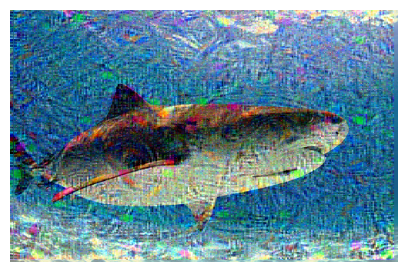

In [23]:
pltshow(wmed_perd)

In [ ]:
def attack_and_record(filename: str,model: nn.Module, imgs:datasets, wm_origin: Tensor):
    block_size = 8
    alpha = 0.1
    beta = 10/255
    l1 = 0.01
    l2 = 0.01
    s_a = 0.0005
    s_b = 0.0001
    N = 20
    alpha_max = 0.2
    beta_max = 20/255
    with open(filename,'a') as file:
        for i in tqdm(range(len(imgs)), desc='Processing'):
            img = imgs[i][0].cuda()
            img = addborder(img,block_size)
            wm = transforms.Resize(img.size()[-2:])(wm_origin)
            target = torch.tensor([imgs[i][1]]).cuda()
            pred_label = model(img.unsqueeze(0)).argmax().item()
            perd_img,wm_extracted,a_res,b_res = fgsm_wm_opti(img,target,wm,model,alpha,beta,block_size,N,l1,l2,s_a,s_b,alpha_max,beta_max)
            res = model(perd_img.unsqueeze(0))
            perd_label = res.argmax().item()
            wm_l2_norm = norm(wm_extracted-wm).item()
            img_l2_norm = norm(perd_img-img).item()
            file.write('{},{},{},{},{},{},{},{}\n'.format(i,imgs[i][1],pred_label,perd_label,wm_l2_norm,img_l2_norm,a_res,b_res))

In [ ]:
def check_result(filename,direct_mode=False):
    cols = ['index','label','pred_label','perd_label','wm_l2','img_l2','alpha','beta']
    if(direct_mode):
        cols = ['index','label','pred_label','perd_label','wm_l2','img_l2']
    res = pd.read_csv(filename,names=cols,header=None)
    print((res['label'] == res['pred_label']).sum())
    print((res['label'] == res['perd_label']).sum())
    print(res['wm_l2'].sum() / res['wm_l2'].count())
    print(res['img_l2'].sum() / res['img_l2'].count())

In [ ]:
filename = '/home/hancy/code/adv_wm/atk_result/fgsm_wm_net_10101456.txt'
attack_and_record(filename,model,imgs,wm_origin)
check_result(filename)

In [ ]:
def attack_and_record_direct(filename: str,model: nn.Module, imgs:datasets, wm_origin: Tensor):
    block_size = 4
    alpha = 0.1
    beta = 5/255
    with open(filename,'a') as file:
        for i in tqdm(range(len(imgs)), desc='Processing'):
            img = imgs[i][0].cuda()
            img = addborder(img,block_size)
            wm = transforms.Resize(img.size()[-2:])(wm_origin)
            target = torch.tensor([imgs[i][1]]).cuda()
            pred_label = model(img.unsqueeze(0)).argmax().item()
            perd_img = fgm_direct(img,target,wm,model,alpha,beta,block_size)
            wm_extracted = extract_wm(img,perd_img,alpha,block_size)
            res = model(perd_img.unsqueeze(0))
            perd_label = res.argmax().item()
            wm_l2_norm = norm(wm_extracted-wm).item()
            img_l2_norm = norm(perd_img-img).item()
            file.write('{},{},{},{},{},{}\n'.format(i,imgs[i][1],pred_label,perd_label,wm_l2_norm,img_l2_norm))